In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
import os
import json
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

2025-05-03 19:44:24.289065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746301464.570730      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746301464.647090      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

train_df = pd.read_csv('/kaggle/input/d/sanskriti10/shl-intern-hiring-assessment/train.csv')
test_df = pd.read_csv('/kaggle/input/d/sanskriti10/shl-intern-hiring-assessment/test.csv')
sample_submission = pd.read_csv('/kaggle/input/d/sanskriti10/shl-intern-hiring-assessment/sample_submission.csv')

with open('/kaggle/input/transcripts/train_transcripts.json', 'r') as f:
    train_transcripts = json.load(f)
with open('/kaggle/input/transcripts/test_transcripts.json', 'r') as f:
    test_transcripts = json.load(f)

In [4]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()
device = torch.device("cpu")
bert_model.to(device)

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:

def extract_audio_features(path):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    return np.concatenate([
        np.mean(mfcc, axis=1),
        np.std(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(spec_contrast, axis=1),
        np.mean(zcr, axis=1)
    ])


In [6]:

def build_features(df, transcripts, audio_dir, is_train=True):
    features = []
    labels = []
    for _, row in df.iterrows():
        fname = row['filename']
        text = transcripts.get(fname, "")
        text_feat = get_bert_embedding(text)
        audio_feat = extract_audio_features(os.path.join(audio_dir, fname))
        combined_feat = np.concatenate([text_feat, audio_feat])
        features.append(combined_feat)
        if is_train:
            labels.append(row['label'])
    return (np.array(features), np.array(labels)) if is_train else np.array(features)

train_audio_dir = '/kaggle/input/shl-audio/train/train'
test_audio_dir = '/kaggle/input/shl-audio/test/test'

X_train, y_train = build_features(train_df, train_transcripts, train_audio_dir)
X_test = build_features(test_df, test_transcripts, test_audio_dir, is_train=False)

In [7]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [8]:

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, train_preds))
pearson_corr, _ = pearsonr(y_train, train_preds)
print(f"Train RMSE: {rmse:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

Train RMSE: 0.0028
Pearson Correlation: 1.0000


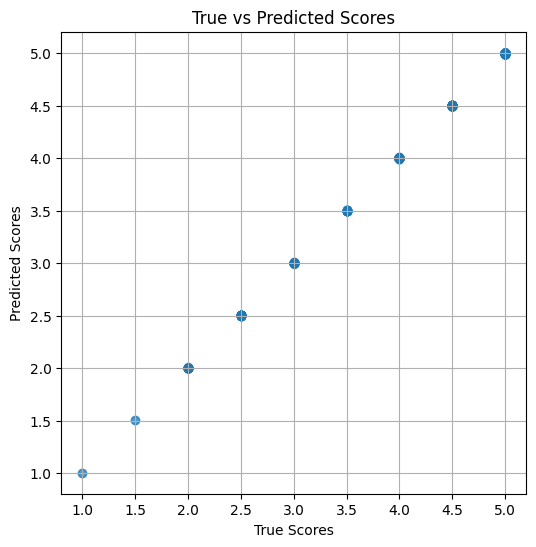

In [9]:

plt.figure(figsize=(6, 6))
plt.scatter(y_train, train_preds, alpha=0.5)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("True vs Predicted Scores")
plt.grid(True)
plt.show()

In [10]:
test_preds = model.predict(X_test)
submission = sample_submission.copy()
submission['label'] = test_preds
submission.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv
